# 中間発表
名前：山口 祐治

課題：House Sales in King County, USA (https://www.kaggle.com/harlfoxem/housesalesprediction/)

In [1]:
%matplotlib inline
from IPython.core.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
import itertools #組み合わせを求めるときに使う
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pyper #pyperとRを事前にインストールしておく必要がある
from sklearn.metrics import mean_squared_error, mean_absolute_error
from common_func import train_and_test

# 前準備（共通関数の用意）

訓練とテストを行うための以下の関数を共通関数として用意した。

def train_and_test(X, y, regr_name="LinearRegression", module_name="sklearn.linear_model")

- 回帰モデルのクラス名を指定できる。モデルの比較評価用。デフォルトは線形回帰
- 訓練とテストのについては、以下の2通りの方法で出力する（クロスバリデーションの効果を確認したかったため）
 - シンプルなテスト(訓練データを80%、テストデータを20%にシンプルに分割し、訓練とテストを行う)
 - cross validation(訓練データ80%、テストデータ20%、分割数5)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import inspect

DEBUG=False

# 訓練とテストを行うための関数
# モデルを指定できる。デフォルトは線形回帰
# 訓練およびテストの方法は、
#  train_and_test_simple: 訓練データを80%、テストデータを20%にシンプルに分割
#  cross_valid: cross validation(訓練データ80%、テストデータ20%)
def train_and_test(X, y, regr_name="LinearRegression", module_name="sklearn.linear_model"):
    print("---", regr_name, "---")
    train_and_test_simple(X, y, regr_name, module_name)
    cross_valid(X, y, regr_name, module_name)
    print("---")
    
def train_and_test_simple(X, y, regr_name="LinearRegression", module_name="sklearn.linear_model"):
    # モジュール名、クラス名からインスタンス生成
    mod = __import__(module_name, fromlist=[regr_name])
    class_def = getattr(mod, regr_name)
    regr = class_def()

    # データを訓練データ80%、テストデータ20%に分割
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 自分の関数名を印字
    print(inspect.currentframe().f_code.co_name)
    
    # 訓練データでの学習、MAEの計算
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred)
    print(" Train MAE: %s"%round(mae,3))

    # テストデータでMAEの計算
    y_pred = regr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(" Test  MAE: %s"%round(mae,3))
    
def cross_valid(X, y, regr_name="LinearRegression", module_name="sklearn.linear_model"):
    # モジュール名、クラス名からクラス定義を取得
    mod = __import__(module_name, fromlist=[regr_name])
    class_def = getattr(mod, regr_name)

    # データを訓練データ80%、テストデータ20%に分割
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train,X_test,y_train,y_test = train_test_split(np.array(X),np.array(y),test_size=0.2,random_state=42)

    kf = KFold(n_splits=5, random_state=1234, shuffle=True)

    df_result = pd.DataFrame()
    models = []
    min_i = -1
    min_mae = -1
    for i,(train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        X_train_train, X_train_val = X_train[train_index], X_train[val_index]
        y_train_train, y_train_val = y_train[train_index], y_train[val_index]

        # クラス定義からインスタンス生成
        regr = class_def()
        regr.fit(X_train_train, y_train_train)
        models.append(regr)
        y_pred = regr.predict(X_train_val)
        df = pd.DataFrame({"y_val":y_train_val, "y_pred":y_pred})
        df_result = pd.concat([df_result, df], axis=0)
    
        # validation dataによる評価指標の算出
        y_val = df_result["y_val"]
        y_pred = df_result["y_pred"]
        mae = mean_absolute_error(y_val, y_pred)
        if DEBUG: print(i)
        if DEBUG: print("MAE=%s"%round(mae,3) )

        if (min_mae < 0 or mae < min_mae):
            min_mae = mae
            min_i = i
            
        if DEBUG: print("MIN MAE=%s"%round(min_mae,3) )

    if DEBUG: print(min_i)

    # 自分の関数名を印字
    print(inspect.currentframe().f_code.co_name)

    y_pred = models[min_i].predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(" Train MAE: %s"%round(min_mae,3))
    print(" Test  MAE: %s"%round(mae,3))


# データの読み込み

In [2]:
df = pd.read_csv("../1_data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# 目的変数と説明変数の関係を確認するためのグラフを作成する

## 散布図での確認

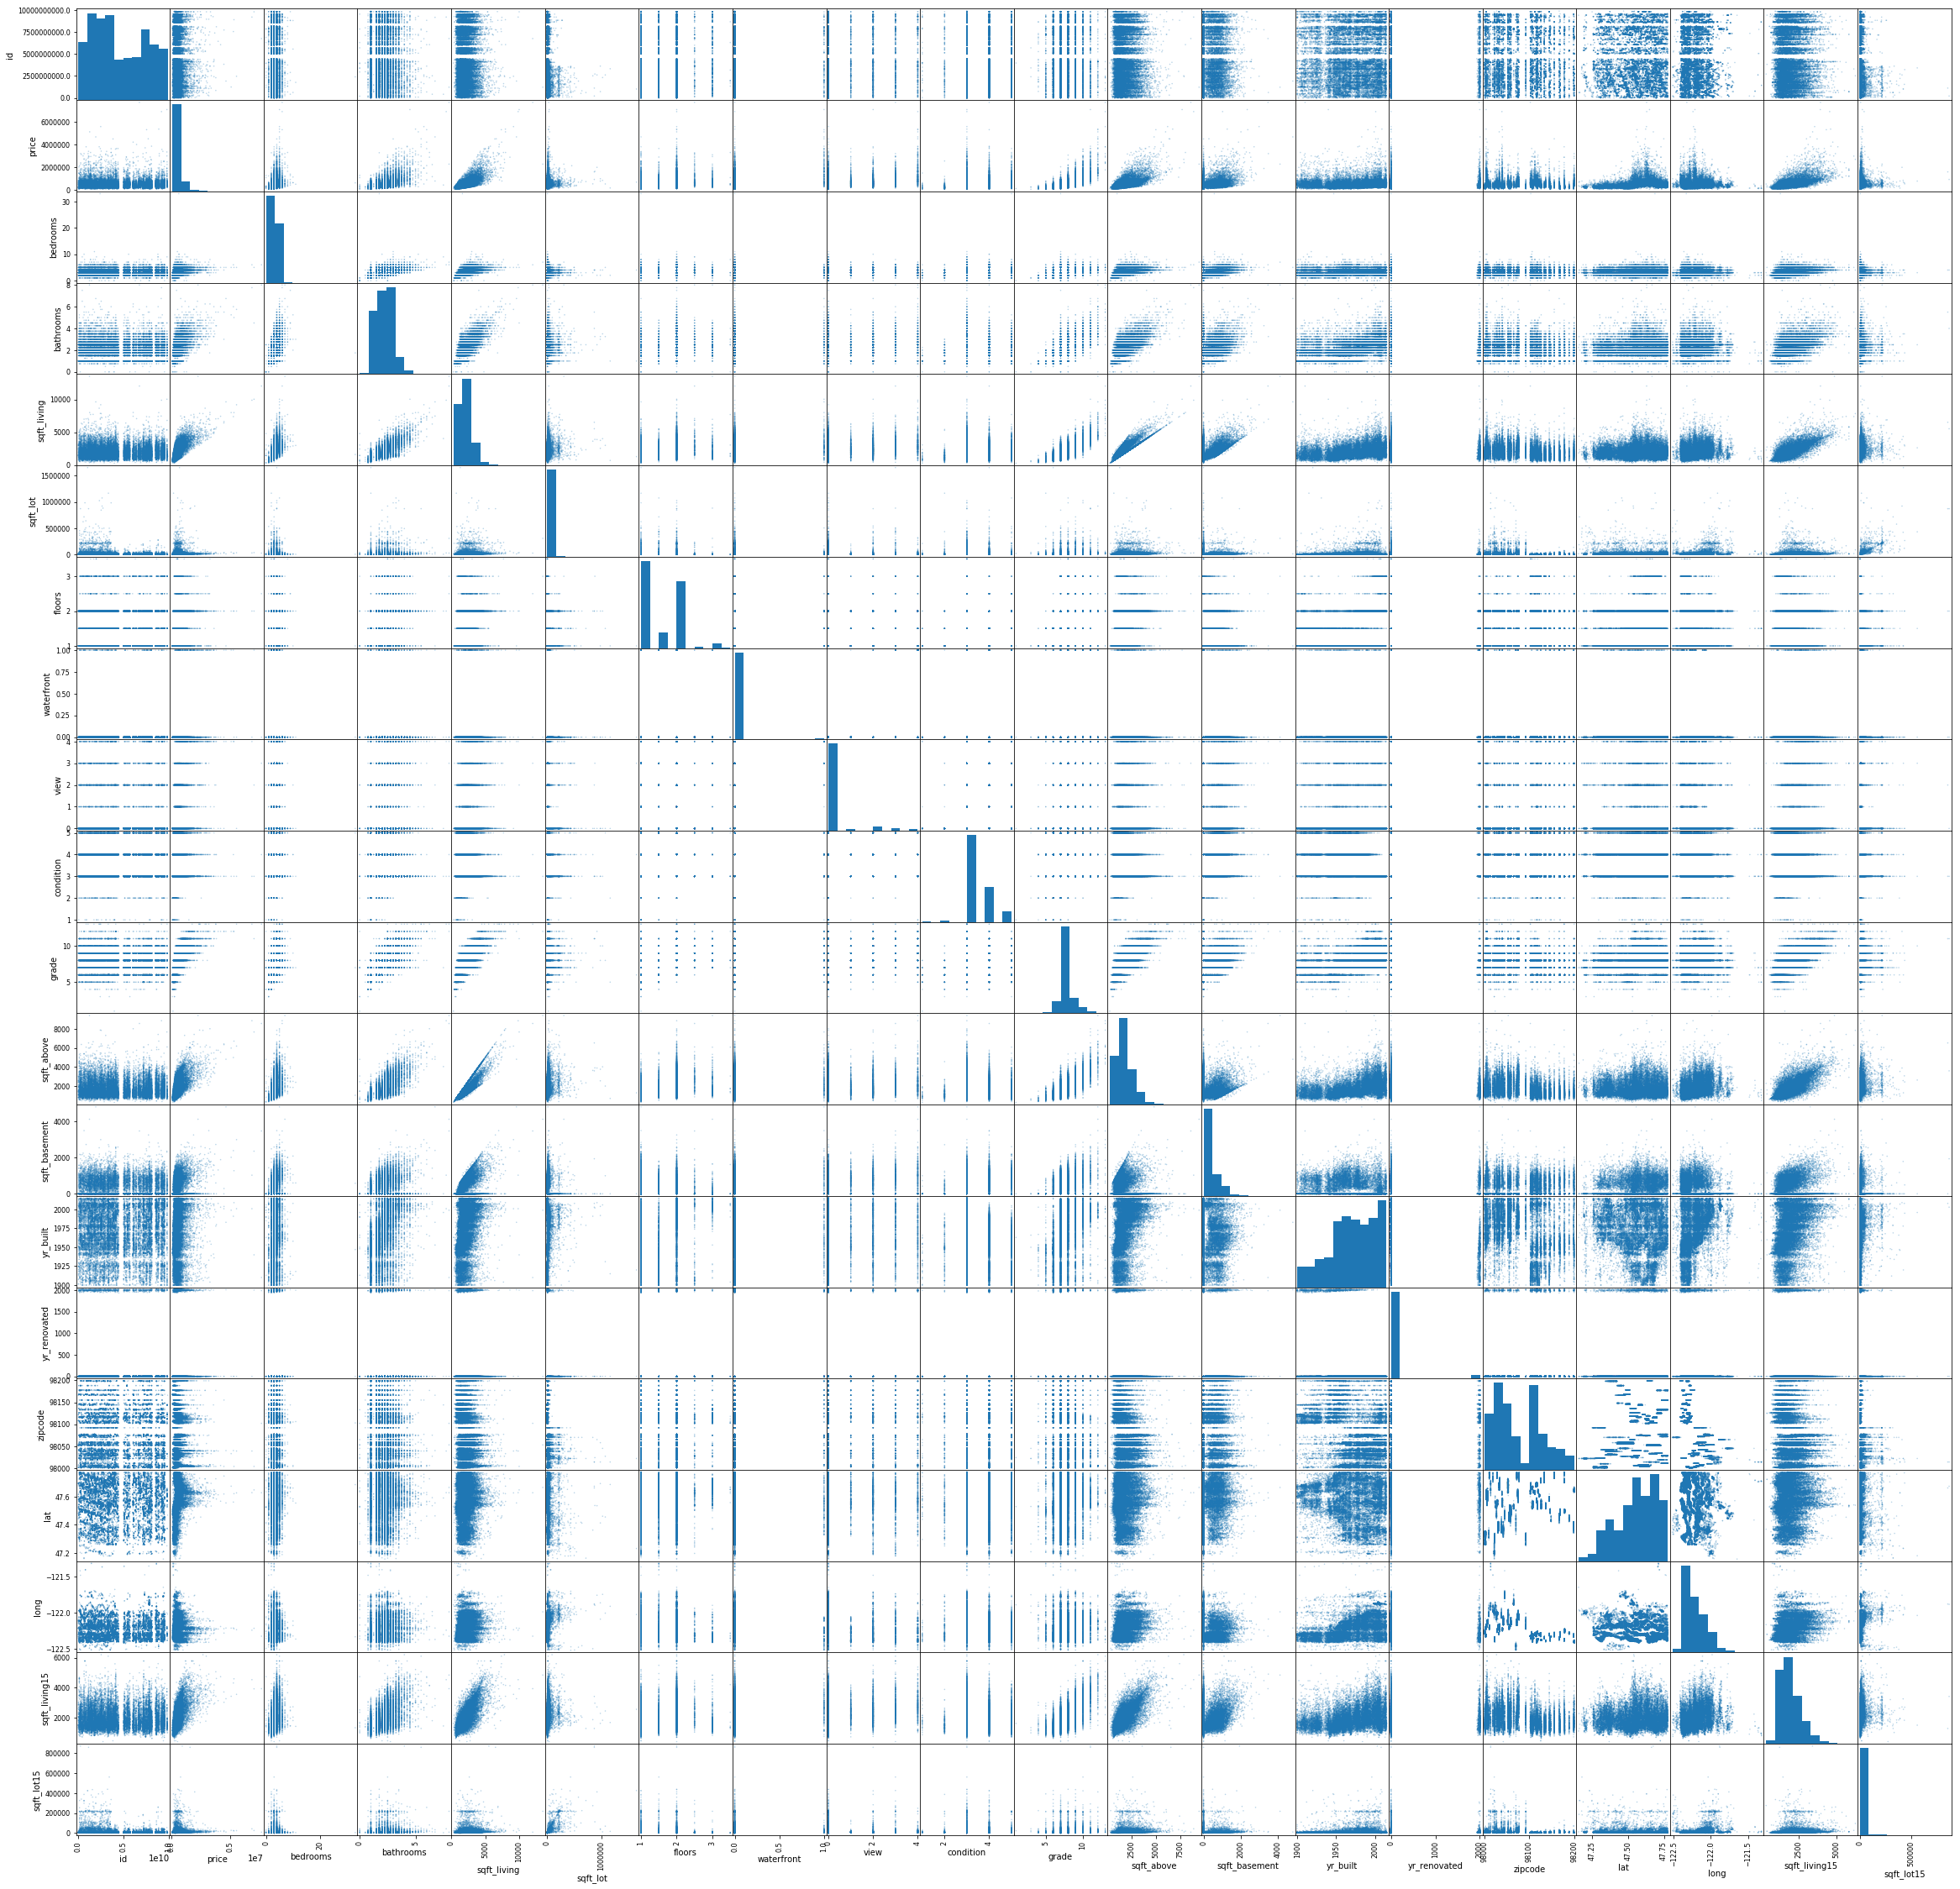

In [3]:
# 散布図の作成
pd.plotting.scatter_matrix(df,alpha=0.3,s=10, figsize=(40,40))
plt.show()

- priceとは、bathrooms, sqft_living, grade, sqft_above, sqft_basementとが相関が高いようにみえる
- ただし、sqft_living=sqft_above+sqft_basementという関係があることに留意する必要がある

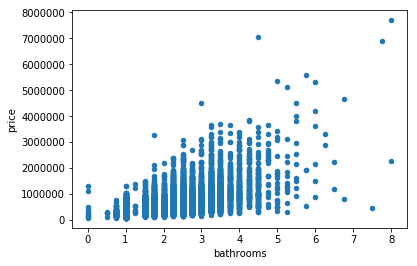

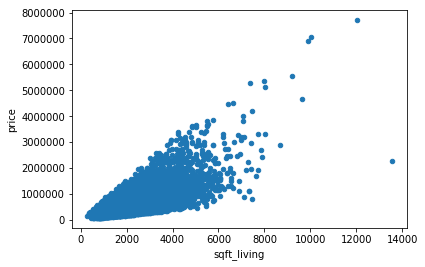

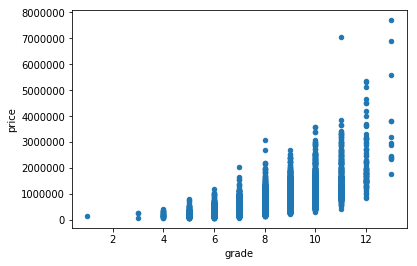

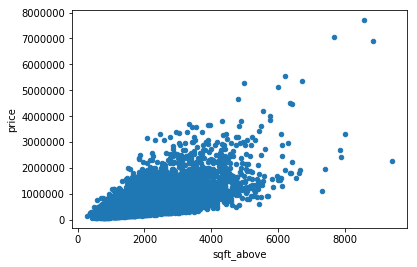

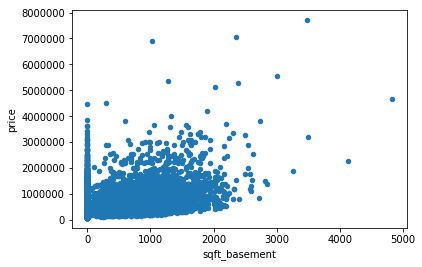

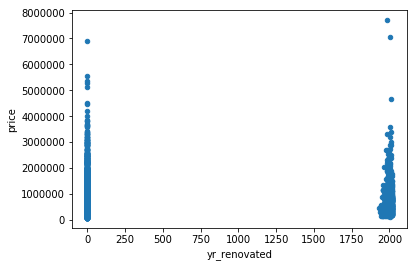

In [14]:
# priceとの相関を個別に可視化
for c in ('bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated'):
    df[[c,'price']].plot(kind='scatter',x=c,y='price')

## 相関係数の可視化

In [5]:
df.corr().style.background_gradient().format('{:.2f}')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.02,-0.01,-0.00,0.02,-0.00,-0.14
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00


- やはり、bathrooms, sqft_living, gradeとの相関が強い。

# 欠測値と異常値を確認する

In [8]:
# Nanの除去
print("df.shape:",df.shape)
df = df.dropna()
print("df.shape:",df.shape)

df.shape: (21613, 21)
df.shape: (21613, 21)


- 欠損値：dropna()を用いて確認したが、特に欠損値はない模様。
- 異常値：上記散布図のヒストグラムを見る限り特に問題はなさそう。ただし、yr_renovatedについては、リフォームした場合は西暦、リフォームしていない場合はゼロが入っているようなので、データとしてあまりよくないように思える。

# 特徴量の変換

## yr_renovatedの変数変換

丸尾先生がslackでyr_renovatedを0,1の値にしてはどうかというコメントがあり、試してみることにした。

In [9]:
df2 = pd.read_csv("../1_data/kc_house_data.csv")

# yr_renovatedを0 or 1に変換してみる
display(df2.head())
df2["yr_renovated"] = df2["yr_renovated"].apply( lambda x: 1 if x > 0 else 0 )
display(df2.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [21]:
# yr_renovated変換前と変換後での成績に違いがあるか確認
# 特徴量変換していないzipcode, dateと、sqft_above, sqft_basementは外している
# （ステップワイズ法、AIC,VIFでの結果を受けてsqft_livingを外している）

# yr_renovated変換前のデータ
X = df.drop(["price", "zipcode", "date", "sqft_living"], axis=1)
y = df["price"]

train_and_test(X, y)

# yr_renovated変換後のデータ
X = df2.drop(["price", "zipcode", "date", "sqft_living"], axis=1)
y = df2["price"]

train_and_test(X, y)

--- LinearRegression ---
train_and_test_simple
 Train MAE: 125362.017
 Test  MAE: 128138.184
cross_valid
 Train MAE: 124693.026
 Test  MAE: 128788.595
---
--- LinearRegression ---
train_and_test_simple
 Train MAE: 125365.834
 Test  MAE: 128142.297
cross_valid
 Train MAE: 124699.214
 Test  MAE: 128792.372
---


それほど違いがないように見える。yr_renovatedの数値変換はそれほど意味がなさそう。
リノベしたかどうかではなく、特定の年を起点とした数値にしたほうがよいかもしれない。

In [22]:
df3 = pd.read_csv("../1_data/kc_house_data.csv")

# 0もしくは1900年を起点としてみる
display(df3.head())
df3["yr_renovated"] = df3["yr_renovated"].apply( lambda x: x - 1900 if x > 0 else 0 )
display(df3.head())

X = df3.drop(["price", "zipcode", "date", "sqft_living"], axis=1)
y = df3["price"]

train_and_test(X, y)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,91,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


--- LinearRegression ---
train_and_test_simple
 Train MAE: 125283.119
 Test  MAE: 128059.159
cross_valid
 Train MAE: 124569.805
 Test  MAE: 128711.519
---


あまり変わらなかった。。。

# 回帰のモデルを試す
RegressorMixinというクラスが回帰のクラスなのようなので、これを使っているクラスを検証してみる。

In [26]:
X = df.drop(["date", "zipcode", "price", "sqft_living"], axis=1);
y = df["price"]

train_and_test(X, y) # 線形回帰
train_and_test(X, y, "DecisionTreeRegressor", "sklearn.tree") # 決定木
train_and_test(X, y, "RandomForestRegressor", "sklearn.ensemble") # ランダムフォレスト
train_and_test(X, y, "AdaBoostRegressor", "sklearn.ensemble") # ブースティング
train_and_test(X, y, "BaggingRegressor", "sklearn.ensemble") # バギング
train_and_test(X, y, "GradientBoostingRegressor", "sklearn.ensemble") # 勾配ブースティング
train_and_test(X, y, "BayesianRidge", "sklearn.linear_model") # ベイズ線形回帰
train_and_test(X, y, "ElasticNet", "sklearn.linear_model") # Elastic Net回帰
train_and_test(X, y, "KNeighborsRegressor", "sklearn.neighbors") # k近傍法
train_and_test(X, y, "MLPRegressor", "sklearn.neural_network") # ニューラルネットワーク
train_and_test(X, y, "LinearSVR", "sklearn.svm") # SVM（線形）
train_and_test(X, y, "ExtraTreeRegressor", "sklearn.tree") # ExtraTreeRegressor
train_and_test(X, y, "Ridge", "sklearn.linear_model") # Ridge
train_and_test(X, y, "Lasso", "sklearn.linear_model") # Lasso


--- LinearRegression ---
train_and_test_simple
 Train MAE: 125362.017
 Test  MAE: 128138.184
cross_valid
 Train MAE: 124693.026
 Test  MAE: 128788.595
---
--- DecisionTreeRegressor ---
train_and_test_simple
 Train MAE: 941.896
 Test  MAE: 105496.686
cross_valid
 Train MAE: 101404.664
 Test  MAE: 106716.981
---
--- RandomForestRegressor ---
train_and_test_simple
 Train MAE: 30415.07
 Test  MAE: 80877.678
cross_valid
 Train MAE: 74042.487
 Test  MAE: 80357.795
---
--- AdaBoostRegressor ---
train_and_test_simple
 Train MAE: 310850.394
 Test  MAE: 314821.133
cross_valid
 Train MAE: 292964.752
 Test  MAE: 274100.44
---
--- BaggingRegressor ---
train_and_test_simple
 Train MAE: 30585.915
 Test  MAE: 81969.798
cross_valid
 Train MAE: 75068.989
 Test  MAE: 80822.275
---
--- GradientBoostingRegressor ---
train_and_test_simple
 Train MAE: 73944.897
 Test  MAE: 83420.783
cross_valid
 Train MAE: 79176.438
 Test  MAE: 84280.226
---
--- BayesianRidge ---
train_and_test_simple
 Train MAE: 125351.877


C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.804367906226517e-22 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.97003596535424e-22 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.027079734944786e-22 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda

 Train MAE: 125361.365
 Test  MAE: 128138.058
cross_valid
 Train MAE: 124692.012
 Test  MAE: 128788.519
---


- ランダムフォレストが一番成績がよかった。平均8万ドル程度の誤差となった（ただし、パラメータチューニングはしていないのであくまでも参考）
- この結果を見る限り、クロスバリデーションの効果は実感できなかった（プログラムのミスの可能性もあるので見直す）



# 参考：丸尾先生の特徴量抽出結果の確認

In [12]:
df_en = df.copy()

# dowとmonthのエンコーディング
df_en['dow'] = pd.to_datetime(df_en.date).map(lambda x:'dow'+str(x.weekday()))
df_en['month'] = pd.to_datetime(df_en.date).map(lambda x:'month'+str(x.month))

# zipcodeのエンコーディング
df_en['zipcode'].astype(str).map(lambda x:x[0:4]).value_counts().sort_index()
df_en['zipcode_4'] = df_en['zipcode'].astype(str).map(lambda x:'zip_'+x[0:4])
df_en = pd.concat([df_en,pd.get_dummies(df_en['zipcode_4'])],axis=1)
df_en = pd.concat([df_en,pd.get_dummies(df_en.dow)],axis=1)
df_en = pd.concat([df_en,pd.get_dummies(df_en.month)],axis=1)

# 変換前の変数を削除
df_en = df_en.drop(['date','zipcode','zipcode_4','month','dow'],axis=1)

# マルチコの削除
df_en = df_en.drop(['sqft_living','zip_9802','month1','dow1'],axis=1)

display(df_en.columns)
display(df_en.head())

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'zip_9800', 'zip_9801', 'zip_9803',
       'zip_9804', 'zip_9805', 'zip_9806', 'zip_9807', 'zip_9809', 'zip_9810',
       'zip_9811', 'zip_9812', 'zip_9813', 'zip_9814', 'zip_9815', 'zip_9816',
       'zip_9817', 'zip_9818', 'zip_9819', 'dow0', 'dow2', 'dow3', 'dow4',
       'dow5', 'dow6', 'month10', 'month11', 'month12', 'month2', 'month3',
       'month4', 'month5', 'month6', 'month7', 'month8', 'month9'],
      dtype='object')

,id,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,...,month11,month12,month2,month3,month4,month5,month6,month7,month8,month9
0,7129300520,221900.0,3,1.00,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
1,6414100192,538000.0,3,2.25,7242,2.0,0,0,3,7,...,0,1,0,0,0,0,0,0,0,0
2,5631500400,180000.0,2,1.00,10000,1.0,0,0,3,6,...,0,0,1,0,0,0,0,0,0,0
3,2487200875,604000.0,4,3.00,5000,1.0,0,0,5,7,...,0,1,0,0,0,0,0,0,0,0
4,1954400510,510000.0,3,2.00,8080,1.0,0,0,3,8,...,0,0,1,0,0,0,0,0,0,0


In [24]:
X = df_en.drop(["price"], axis=1);
y = df_en["price"]

train_and_test(X, y) # 線形回帰
train_and_test(X, y, "DecisionTreeRegressor", "sklearn.tree") # 決定木
train_and_test(X, y, "RandomForestRegressor", "sklearn.ensemble") # ランダムフォレスト
train_and_test(X, y, "AdaBoostRegressor", "sklearn.ensemble") # ブースティング
train_and_test(X, y, "BaggingRegressor", "sklearn.ensemble") # バギング
train_and_test(X, y, "GradientBoostingRegressor", "sklearn.ensemble") # 勾配ブースティング
train_and_test(X, y, "BayesianRidge", "sklearn.linear_model") # ベイズ線形回帰
train_and_test(X, y, "ElasticNet", "sklearn.linear_model") # Elastic Net回帰
train_and_test(X, y, "KNeighborsRegressor", "sklearn.neighbors") # k近傍法
train_and_test(X, y, "MLPRegressor", "sklearn.neural_network") # ニューラルネットワーク
train_and_test(X, y, "LinearSVR", "sklearn.svm") # SVM（線形）
train_and_test(X, y, "ExtraTreeRegressor", "sklearn.tree") # ExtraTreeRegressor
train_and_test(X, y, "Ridge", "sklearn.linear_model") # Ridge
train_and_test(X, y, "Lasso", "sklearn.linear_model") # Lasso


--- LinearRegression ---
train_and_test_simple
 Train MAE: 118284.138
 Test  MAE: 121103.448
cross_valid
 Train MAE: 118520.56
 Test  MAE: 122020.001
---
--- DecisionTreeRegressor ---
train_and_test_simple
 Train MAE: 0.0
 Test  MAE: 106804.927
cross_valid
 Train MAE: 103775.55
 Test  MAE: 111938.213
---
--- RandomForestRegressor ---
train_and_test_simple
 Train MAE: 30354.028
 Test  MAE: 80202.651
cross_valid
 Train MAE: 74482.614
 Test  MAE: 81129.475
---
--- AdaBoostRegressor ---
train_and_test_simple
 Train MAE: 314730.876
 Test  MAE: 318407.434
cross_valid
 Train MAE: 310033.954
 Test  MAE: 295453.058
---
--- BaggingRegressor ---
train_and_test_simple
 Train MAE: 30039.933
 Test  MAE: 80836.586
cross_valid
 Train MAE: 74604.205
 Test  MAE: 80507.151
---
--- GradientBoostingRegressor ---
train_and_test_simple
 Train MAE: 73777.091
 Test  MAE: 83037.544
cross_valid
 Train MAE: 78389.297
 Test  MAE: 83156.456
---
--- BayesianRidge ---
train_and_test_simple
 Train MAE: 118234.907
 Tes

C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8496457742415417e-22 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8733845182508757e-22 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.896785370511026e-22 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\yuji-yamaguchi\AppData\Local\Continuum\anaco

cross_valid
 Train MAE: 118491.385
 Test  MAE: 121991.783
---
--- Lasso ---
train_and_test_simple
 Train MAE: 118281.817
 Test  MAE: 121100.232
cross_valid
 Train MAE: 118517.309
 Test  MAE: 122016.266
---


- やはりランダムフォレストが一番成績がよい。ただし、8万1000ドルぐらいと若干悪い。
- 線形回帰の成績は若干よくなっている